In [58]:
import pandas as pd 
from typing import Callable, List
import datasets 
from huggingface_hub import snapshot_download
from pathlib import Path
import seaborn as sns
import json
import matplotlib.pyplot as plt
from adjustText import adjust_text
import matplotlib.ticker as ticker


In [31]:
read_table = lambda item: pd.DataFrame(item[1:], columns=item[0])

def set_theme():
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.rc('legend', fontsize=12) #fontsize of the legend
    plt.rc('axes', labelsize=14)

In [5]:
# FetaQA
fetaqa_test = datasets.load_dataset("target-benchmark/fetaqa-corpus", split='test')
fetaqa_dfs: List[pd.DataFrame] = [read_table(item['table']) for item in fetaqa_test]

In [6]:
# TabFact 
tabfact_test = datasets.load_dataset("target-benchmark/tabfact-corpus", split='test')
tabfact_dfs: List[pd.DataFrame] = [read_table(item['table']) for item in tabfact_test]

Repo card metadata block was not found. Setting CardData to empty.


In [7]:
# OTTQA
ottqa_validation = datasets.load_dataset("target-benchmark/ottqa-corpus", split='validation')
ottqa_dfs: List[pd.DataFrame] = [read_table(item['table']) for item in ottqa_validation]

In [8]:
# BIRD
path_to_data_dir = snapshot_download(repo_id="target-benchmark/bird-corpus-validation", repo_type="dataset")
path_to_context = Path(path_to_data_dir, f"bird-corpus-validation.json")
with open(path_to_context, "r") as file:
    bird_validation = json.load(file)
bird_dfs: List[pd.DataFrame] = [read_table(item) for item in bird_validation['table']]

Fetching 104 files:   0%|          | 0/104 [00:00<?, ?it/s]

In [13]:
# Spider 
path_to_data_dir = snapshot_download(repo_id="target-benchmark/spider-corpus-test", repo_type="dataset")
path_to_context = Path(path_to_data_dir, f"spider-corpus-test.json")
with open(path_to_context, "r") as file:
    spider_test = json.load(file)
spider_dfs: List[pd.DataFrame] = [read_table(item) for item in spider_test['table']]

Fetching 132 files:   0%|          | 0/132 [00:00<?, ?it/s]

In [61]:
table_metadata = []
for name, dfs in [('FetaQA', fetaqa_dfs), ('TabFact', tabfact_dfs), ('OTTQA', ottqa_dfs), ('Bird', bird_dfs), ('Spider', spider_dfs)]:
    for df in dfs:
        table_metadata.append(
            {
                "Dataset": name,
                "# Rows": len(df),
                "# Columns": len(df.columns),
            }
        )
metadata_df = pd.DataFrame(table_metadata)

In [20]:
metadata_df

,dataset,num_rows,num_columns
0,FetaQA,8,4
1,FetaQA,4,4
2,FetaQA,23,4
3,FetaQA,20,5
4,FetaQA,23,11
...,...,...,...
4737,Spider,11,7
4738,Spider,9,5
4739,Spider,8,3
4740,Spider,5,7


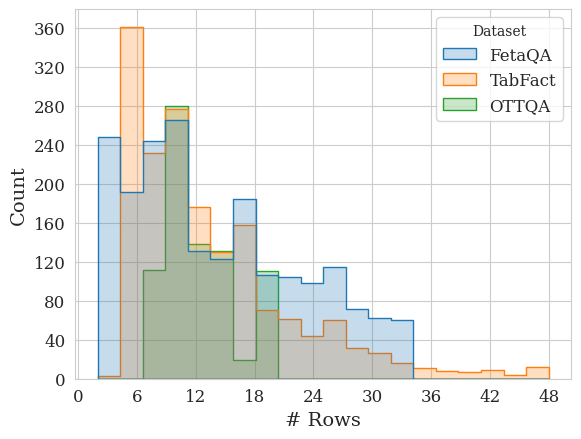

In [70]:
set_theme()
plot = sns.histplot(data=metadata_df[~metadata_df['Dataset'].isin(['Bird', 'Spider'])], x="# Rows", hue="Dataset", element="step", bins=20)
plot.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plot.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.savefig('non-sql-row-counts.pdf', bbox_inches='tight')

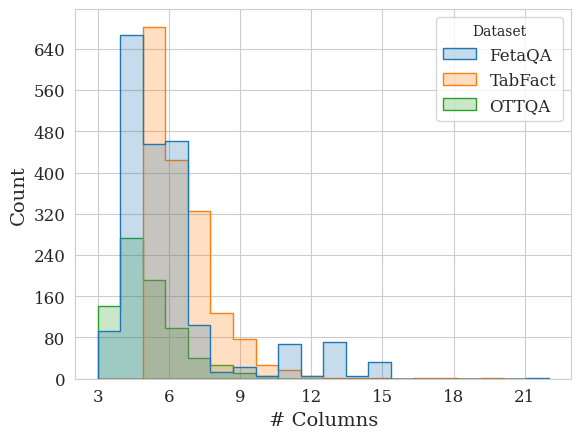

In [71]:
set_theme()
plot = sns.histplot(data=metadata_df[~metadata_df['Dataset'].isin(['Bird', 'Spider'])], x="# Columns", hue="Dataset", element="step", bins=20)
plot.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plot.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.savefig('non-sql-column-counts.pdf', bbox_inches='tight')

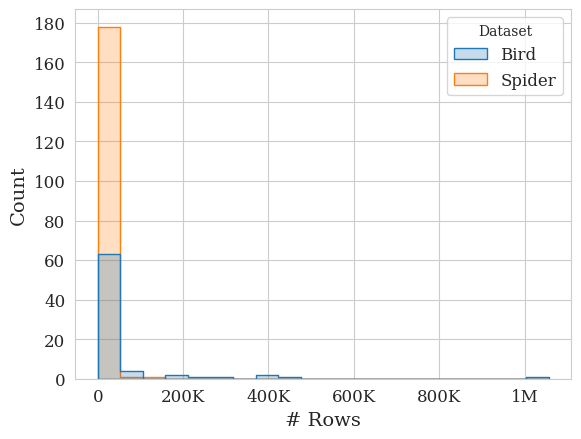

In [78]:
set_theme()
def format_func(x, p):
    if x >= 1000000:
        return f'{x/1000000:.0f}M'
    elif x >= 1000:
        return f'{x/1000:.0f}K'
    else:
        return f'{x:.0f}'
plot = sns.histplot(data=metadata_df[metadata_df['Dataset'].isin(['Bird', 'Spider'])], x="# Rows", hue="Dataset", element="step", bins=20)
plot.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plot.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.savefig('sql-row-counts.pdf', bbox_inches='tight')

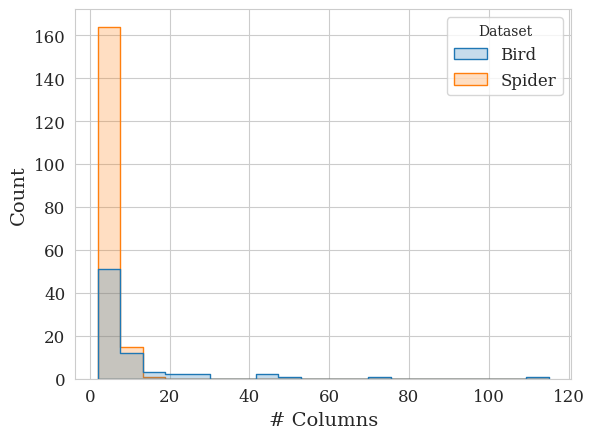

In [77]:
set_theme()
sns.histplot(data=metadata_df[metadata_df['Dataset'].isin(['Bird', 'Spider'])], x="# Columns", hue="Dataset", element="step", bins=20)
plot.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plot.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.savefig('sql-column-counts.pdf', bbox_inches='tight')

In [81]:
# Averages 
set_theme()
average_df = metadata_df.groupby('Dataset')['# Rows'].mean().reset_index().merge(metadata_df.groupby('Dataset')['# Columns'].mean().reset_index()).rename(columns={"# Rows": "Average # Rows", "# Columns": "Average # Columns"})
average_df
# plot = sns.scatterplot(data=average_df, x="Average # Rows", y="Average # Columns", hue="dataset")
# texts = []
# for line in range(0, average_df.shape[0]):
#     texts.append(plt.text(average_df["Average # Rows"].iloc[line], 
#                          average_df["Average # Columns"].iloc[line], 
#                          average_df["dataset"].iloc[line]))
# plt.legend([])
# plot.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# plot.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# 
# adjust_text(texts)

,Dataset,Average # Rows,Average # Columns
0,Bird,52436.466667,10.640000
1,FetaQA,14.157763,5.698952
2,OTTQA,12.397972,4.717364
3,Spider,1364.300000,4.361111
4,TabFact,13.432448,6.252507


In [ ]:
.merge(metadata_df.groupby('Dataset')['# Columns'].mean().reset_index())